In [53]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import os


In [54]:

from datetime import datetime
now = datetime.now()
formatted_date = now.strftime("%m%d")
formatted_date = int(formatted_date)
print(formatted_date)

home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)
save_directory = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001', 'AVEHdata_pre_result') #保存先のファイル名を入力
print(save_directory)
os.makedirs(save_directory, exist_ok=True)


118
C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\AVEHdata_pre_result


In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [56]:


# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング

# データセットを分割（train, test）
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# NumPy配列をPyTorchのTensorに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)  # 分類用ラベル
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# TensorDatasetを作成
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoaderを作成（バッチ処理用）
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 動作確認
for batch_X, batch_y in train_loader:
    print("Batch X Shape:", batch_X.shape)
    print("Batch y Shape:", batch_y.shape)
    break


Batch X Shape: torch.Size([32, 6])
Batch y Shape: torch.Size([32])


In [66]:

for batch_X, batch_y in test_loader:
    first_batch_X = batch_X
    break
# 特徴量ごとの有効数字の設定（例: エンジン回転数は3桁、圧力は4桁）
significant_digits = {
    'Engine rpm': 3,
    'Lub oil pressure': 8,
    'Fuel pressure': 8,
    'Coolant pressure': 8,
    'lub oil temp': 7,
    'Coolant temp': 7
}

# 有効数字を適用する関数
def apply_significant_digits(value, digits):
    if value == 0:
        return 0
    else:
        return round(value, digits - int(np.floor(np.log10(abs(value)))) - 1)
X_original = first_batch_X.numpy() * scaler.scale_ + scaler.mean_
columns = data.columns.drop('Engine Condition')  # 元の特徴量名を使用
restored_df = pd.DataFrame(X_original, columns=columns)
# 各特徴量に有効数字を適用
for column, digits in significant_digits.items():
    if column in restored_df.columns:
        restored_df[column] = restored_df[column].apply(apply_significant_digits, args=(digits,))

# 結果の表示
print("有効数字を適用した特徴量:")
print(restored_df.head(5).to_string(index=False))


有効数字を適用した特徴量:
 Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  lub oil temp  Coolant temp
      682.0          2.391656       4.617196          2.848982      76.27242      69.88461
      605.0          5.466877       6.424361          5.727520      73.22268      74.90731
      658.0          3.434232       3.680896          1.678708      88.08992      78.70481
      749.0          2.094657       7.120927          1.639670      77.66163      82.38670
      676.0          3.538228       5.956472          3.225336      75.22635      67.15322


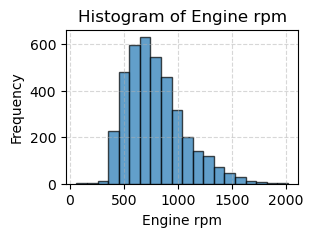

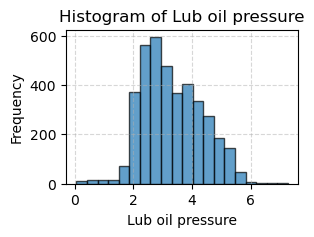

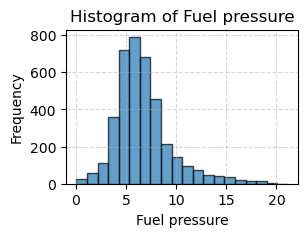

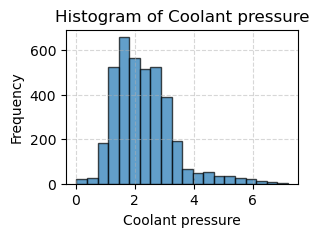

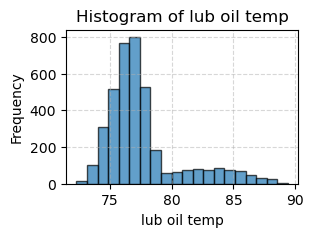

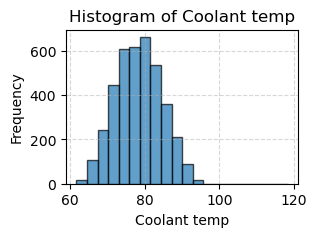

In [71]:
all_original_X = []
for batch_X, _ in test_loader:
    # 標準化を元に戻す (scaler.mean_ と scaler.scale_ を使用)
    original_X = batch_X.numpy() * scaler.scale_ + scaler.mean_
    all_original_X.append(original_X)  # 元に戻したデータをリストに追加

# 全体を NumPy 配列に変換
all_original_X = np.vstack(all_original_X)  # バッチごとに縦に結合

# ヒストグラムを特徴量ごとに作成
for i, column in enumerate(columns):  # columns は restored_df の列名を使用
    plt.figure(figsize=(3, 2))  # 各ヒストグラムのサイズを設定
    plt.hist(all_original_X[:, i], bins=20, edgecolor='k', alpha=0.7)
    plt.title(f'Histogram of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

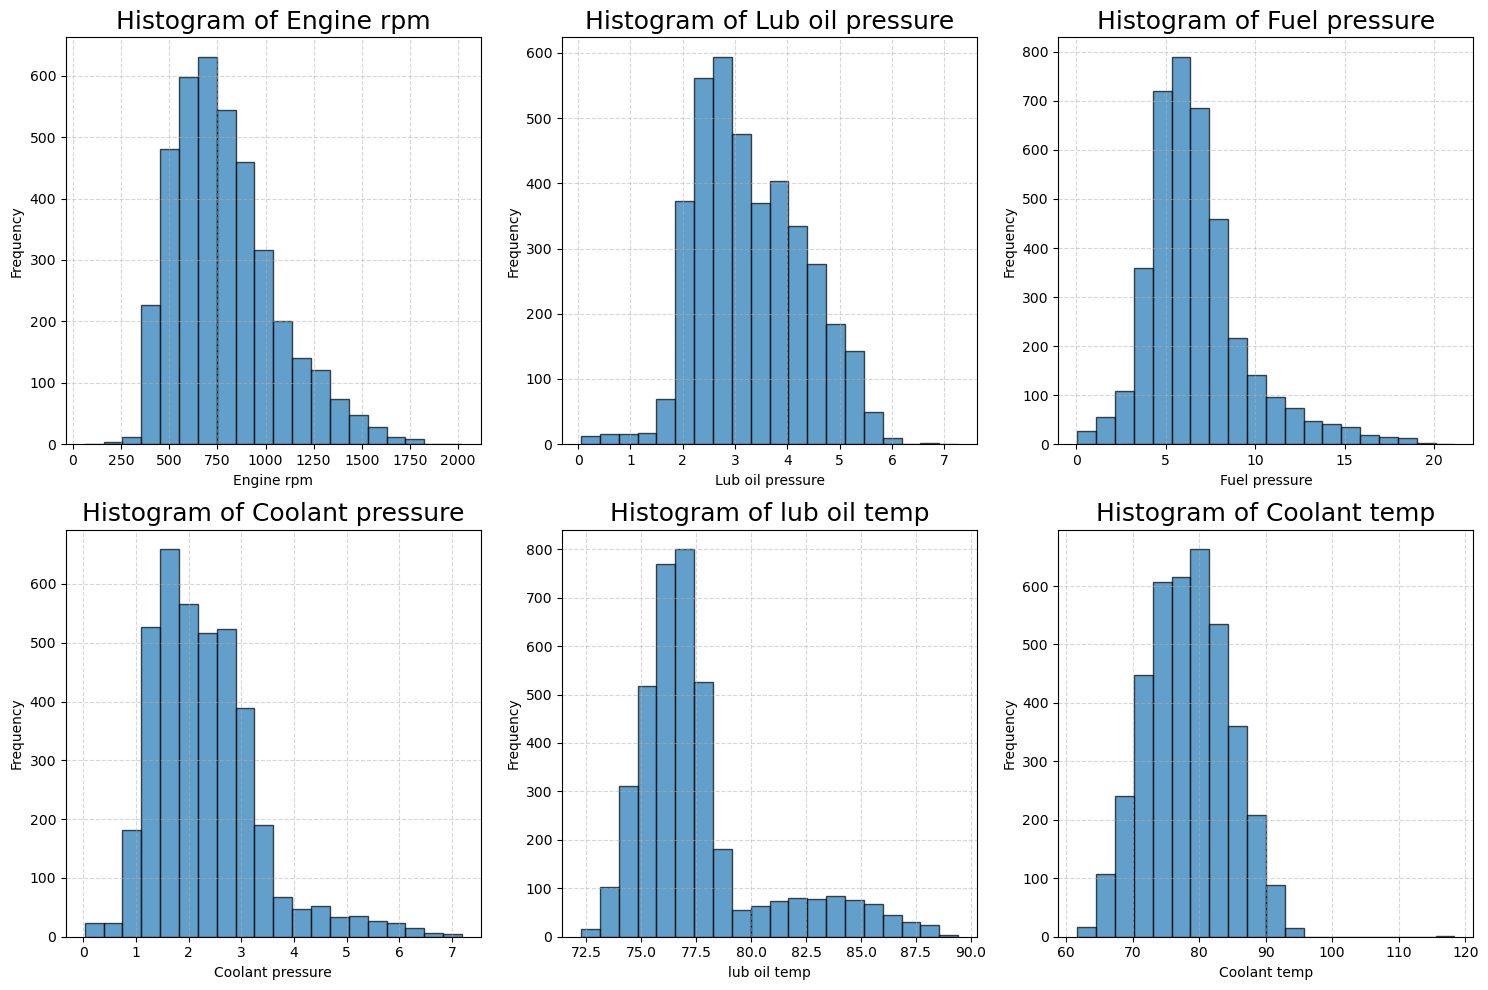

In [78]:
def plot_histograms(all_X, scaler, columns):

    # バッチデータを1つの配列に結合
    all_X_combined = np.vstack(all_X)

    # 標準化を元に戻す
    all_original_X = all_X_combined * scaler.scale_ + scaler.mean_

    # ヒストグラムを特徴量ごとに作成
    num_features = len(columns)  # 特徴量の数
    rows = (num_features + 2) // 3  # 3列2行で表示するための行数計算
    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))

    # 各特徴量のヒストグラムをプロット
    for i, column in enumerate(columns):  # columns は特徴量名を使用
        row, col = divmod(i, 3)
        ax = axes[row, col]
        ax.hist(all_original_X[:, i], bins=20, edgecolor='k', alpha=0.7)
        ax.set_title(f'Histogram of {column}',fontsize=18)
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')
        ax.grid(True, linestyle='--', alpha=0.5)

    # 空白のプロットを削除
    for j in range(num_features, rows * 3):
        fig.delaxes(axes.flatten()[j])

    plt.tight_layout()
    plt.show()


# 使用例
all_X = []
for batch_X, _ in test_loader:
    all_X.append(batch_X.numpy())

plot_histograms(all_X, scaler, columns)

In [67]:
def TableCreater(batch_X, scaler, columns):

    # 有効数字の定義
    significant_digits = {
        'Engine rpm': 3,
        'Lub oil pressure': 8,
        'Fuel pressure': 8,
        'Coolant pressure': 8,
        'lub oil temp': 7,
        'Coolant temp': 7
    }

    # 有効数字を適用する関数
    def apply_significant_digits(value, digits):
        if value == 0:
            return 0
        else:
            return round(value, digits - int(np.floor(np.log10(abs(value)))) - 1)

    # スケールを元に戻す
    X_original = batch_X.numpy() * scaler.scale_ + scaler.mean_
    restored_df = pd.DataFrame(X_original, columns=columns)

    # 各特徴量に有効数字を適用
    for column, digits in significant_digits.items():
        if column in restored_df.columns:
            restored_df[column] = restored_df[column].apply(apply_significant_digits, args=(digits,))

    return restored_df.head(5)  # 最初の5行を返す

# テストバッチの処理
for batch_X, batch_y in test_loader:
    processed_df = TableCreater(batch_X, scaler, data.columns.drop('Engine Condition'))
    break

# 結果の表示
print(processed_df.to_string(index=False))

 Engine rpm  Lub oil pressure  Fuel pressure  Coolant pressure  lub oil temp  Coolant temp
      682.0          2.391656       4.617196          2.848982      76.27242      69.88461
      605.0          5.466877       6.424361          5.727520      73.22268      74.90731
      658.0          3.434232       3.680896          1.678708      88.08992      78.70481
      749.0          2.094657       7.120927          1.639670      77.66163      82.38670
      676.0          3.538228       5.956472          3.225336      75.22635      67.15322
